In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'LinearModel'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': None,
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class LinearModel(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define linear model
        self.TextModel = nn.Linear(25, 1)

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = LinearModel().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 26


In [13]:
# Do not traing if already trained
if Path(f'../models/{model_name}/state_dict.pt').is_file():
    # Load optimal weights
    model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
    print('Skipping training and loading optimal weights from previous training!')
else:
    # Train model
    model, history = sf.train_model(
        model=model,
        dataset_train=subsets['train'],
        dataset_val=subsets['val'],

        # Define loss & optimizer
        loss_function=nn.MSELoss().to(device),
        optimizer=torch.optim.SGD(model.parameters(), lr=.1),

        # Define computing device
        device=device,

        # Define training parameters
        epochs=50,
        patience=50,
        delta=0,
        batch_size=len(dataset),
        shuffle=True,
        num_workers=0,
        pin_memory=True,

        # Define save locations
        save_state_dict_as=f'../models/{model_name}/state_dict.pt',
        save_history_as=f'../models/{model_name}/history.csv'
        )

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch  1/50: RMSE_train: 1,734,424, RMSE_val: 1,517,716


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch  2/50: RMSE_train: 1,547,558, RMSE_val: 1,420,145


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch  3/50: RMSE_train: 1,426,439, RMSE_val: 1,350,357


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Epoch  4/50: RMSE_train: 1,344,822, RMSE_val: 1,314,548


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch  5/50: RMSE_train: 1,289,824, RMSE_val: 1,295,775


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch  6/50: RMSE_train: 1,253,055, RMSE_val: 1,290,230


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch  7/50: RMSE_train: 1,228,637, RMSE_val: 1,292,622
EarlyStopping counter: 1 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Epoch  8/50: RMSE_train: 1,212,475, RMSE_val: 1,300,343
EarlyStopping counter: 2 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch  9/50: RMSE_train: 1,201,777, RMSE_val: 1,311,356
EarlyStopping counter: 3 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 10/50: RMSE_train: 1,194,667, RMSE_val: 1,324,438
EarlyStopping counter: 4 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 11/50: RMSE_train: 1,189,905, RMSE_val: 1,338,749
EarlyStopping counter: 5 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 12/50: RMSE_train: 1,186,679, RMSE_val: 1,353,753
EarlyStopping counter: 6 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch 13/50: RMSE_train: 1,184,457, RMSE_val: 1,369,094
EarlyStopping counter: 7 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 14/50: RMSE_train: 1,182,894, RMSE_val: 1,384,536
EarlyStopping counter: 8 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 15/50: RMSE_train: 1,181,767, RMSE_val: 1,399,921
EarlyStopping counter: 9 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 16/50: RMSE_train: 1,180,929, RMSE_val: 1,415,143
EarlyStopping counter: 10 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 17/50: RMSE_train: 1,180,284, RMSE_val: 1,430,130
EarlyStopping counter: 11 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch 18/50: RMSE_train: 1,179,773, RMSE_val: 1,444,833
EarlyStopping counter: 12 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 19/50: RMSE_train: 1,179,353, RMSE_val: 1,459,219
EarlyStopping counter: 13 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch 20/50: RMSE_train: 1,178,999, RMSE_val: 1,473,265
EarlyStopping counter: 14 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 21/50: RMSE_train: 1,178,692, RMSE_val: 1,486,955
EarlyStopping counter: 15 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch 22/50: RMSE_train: 1,178,421, RMSE_val: 1,500,282
EarlyStopping counter: 16 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch 23/50: RMSE_train: 1,178,177, RMSE_val: 1,513,238
EarlyStopping counter: 17 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 24/50: RMSE_train: 1,177,955, RMSE_val: 1,525,823
EarlyStopping counter: 18 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch 25/50: RMSE_train: 1,177,751, RMSE_val: 1,538,037
EarlyStopping counter: 19 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch 26/50: RMSE_train: 1,177,563, RMSE_val: 1,549,880
EarlyStopping counter: 20 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 27/50: RMSE_train: 1,177,387, RMSE_val: 1,561,358
EarlyStopping counter: 21 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch 28/50: RMSE_train: 1,177,224, RMSE_val: 1,572,473
EarlyStopping counter: 22 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch 29/50: RMSE_train: 1,177,070, RMSE_val: 1,583,232
EarlyStopping counter: 23 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 30/50: RMSE_train: 1,176,926, RMSE_val: 1,593,640
EarlyStopping counter: 24 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch 31/50: RMSE_train: 1,176,791, RMSE_val: 1,603,704
EarlyStopping counter: 25 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 32/50: RMSE_train: 1,176,663, RMSE_val: 1,613,432
EarlyStopping counter: 26 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Epoch 33/50: RMSE_train: 1,176,542, RMSE_val: 1,622,830
EarlyStopping counter: 27 out of 50


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch 34/50: RMSE_train: 1,176,429, RMSE_val: 1,631,906
EarlyStopping counter: 28 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 35/50: RMSE_train: 1,176,321, RMSE_val: 1,640,669
EarlyStopping counter: 29 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 36/50: RMSE_train: 1,176,219, RMSE_val: 1,649,126
EarlyStopping counter: 30 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch 37/50: RMSE_train: 1,176,122, RMSE_val: 1,657,284
EarlyStopping counter: 31 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch 38/50: RMSE_train: 1,176,030, RMSE_val: 1,665,153
EarlyStopping counter: 32 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch 39/50: RMSE_train: 1,175,943, RMSE_val: 1,672,741
EarlyStopping counter: 33 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch 40/50: RMSE_train: 1,175,860, RMSE_val: 1,680,054
EarlyStopping counter: 34 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Epoch 41/50: RMSE_train: 1,175,781, RMSE_val: 1,687,102
EarlyStopping counter: 35 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 42/50: RMSE_train: 1,175,706, RMSE_val: 1,693,892
EarlyStopping counter: 36 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch 43/50: RMSE_train: 1,175,634, RMSE_val: 1,700,432
EarlyStopping counter: 37 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Epoch 44/50: RMSE_train: 1,175,566, RMSE_val: 1,706,730
EarlyStopping counter: 38 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch 45/50: RMSE_train: 1,175,501, RMSE_val: 1,712,794
EarlyStopping counter: 39 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Epoch 46/50: RMSE_train: 1,175,439, RMSE_val: 1,718,630
EarlyStopping counter: 40 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 47/50: RMSE_train: 1,175,379, RMSE_val: 1,724,246
EarlyStopping counter: 41 out of 50


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 48/50: RMSE_train: 1,175,322, RMSE_val: 1,729,649
EarlyStopping counter: 42 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 49/50: RMSE_train: 1,175,268, RMSE_val: 1,734,847
EarlyStopping counter: 43 out of 50


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

Epoch 50/50: RMSE_train: 1,175,215, RMSE_val: 1,739,845
EarlyStopping counter: 44 out of 50


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset         RMSE         MAE   MAPE      R2
----------------------------------------------
train   1228636.547  700774.938  0.877   0.032
val     1290230.280  693385.272  0.916  -0.086
test    1220141.217  691211.591  0.850   0.038
----------------------------------------------
total   1233247.852  698123.409  0.876   0.021


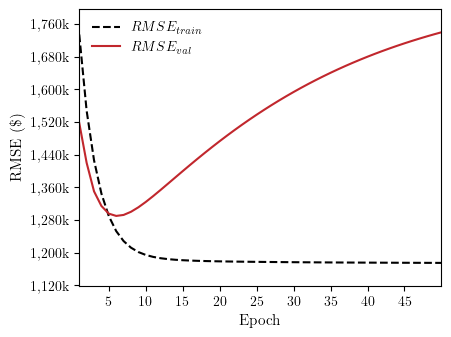

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

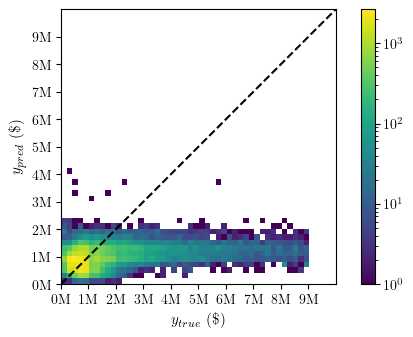

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')